This notebook is better viewed with nbviewer:

[http://nbviewer.jupyter.org/gist/mbanga9/8898bb8758589fb5c3be4b282b56cb91]

The process shown in this notebook is only the final data processing and analysis. The date retrieval, cleaning and other wrangling can be seen in the `data_processing.py` file, which is the main function called in order to perform the initial part of the data pipeline.

In [1]:
# External libraries used for data handling:
import os
import warnings
import pandas as pd
from datetime import datetime
from dateutil import parser
import pickle
%pylab inline
# Packages for LDA
from gensim.models import Phrases
from gensim.models.word2vec import LineSentence
from gensim.models.ldamulticore import LdaMulticore
from gensim.corpora import Dictionary, MmCorpus
import pyLDAvis # LDA visualisation
import pyLDAvis.gensim
# Helper functions
from lda_helper import *

Populating the interactive namespace from numpy and matplotlib


/home/mbanga/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [150]:
# Importing the DataFrames created using data_processing.py
df = pd.read_csv('df_GDL_all.csv')
df2 = pd.read_csv('df_JDG_all.csv')
df = df.append(df2)
df.reset_index(inplace=True)

# parsing all text to strings
df.text=df.text.apply(lambda x: str(x))
# parsing the strings in 'date' column to a pandas Timestamp
df.date = df.date.apply(lambda x: parser.parse(x))

In [151]:
df=df.drop(['index','Unnamed: 0', 'Unnamed: 0.1'],axis=1)
df.head()

,date,newspaper,text
0,1798-02-02,GDL,membre lecture lettre berne janvier conseil ce...
1,1798-02-05,GDL,charger arrêter constitution fonder biser libe...
2,1798-02-24,GDL,donner nommer acte fou élection décret antérie...
3,1798-03-02,GDL,patrie droit nationale vouloir déchirer indign...
4,1798-03-13,GDL,séparation droit voter fauteur orange ennemi f...


In [386]:
df_new.shape

(359038, 10)

In [390]:
# adding a year and month column
df_new = pd.DataFrame(columns=['year', 'month'])
df_new.year = df.date.apply(lambda x: datetime.strftime(x, '%Y'))
df_new.month = df.date.apply(lambda x: datetime.strftime(x, '%m'))
df = df.join(df_new, how='outer')

In [392]:
df.to_csv('df_all_merged.csv')

In [393]:
type(df.date[0])
# Selection of articles between dates can be done like so:
# df.date = df.date.apply(lambda x: parser.parse(x))
# df.set_index=('date', inplace=True)
# df[datetime(1851,1,24):datetime(1852,8,22)]

pandas._libs.tslib.Timestamp

# Latent Dirchlet Allocation (LDA)
The following files are created during this section and can be loaded to resume from a previous point:
* dico.pickle
* corpus.mm
* lda_model_all
* lda_model_all.id2word  
* lda_model_all.expElogbeta.npy 
* lda_model_all.state
* LDAvis_prepared

The following steps are performed before the actual LDA
* Dictionary: this is a list of all vocabulary used in our corpus
* Bag of Words (BoW): the famous BoW mentioned in lectures, this is a mapping between the unique ID of a word and its frequency. There are as many BoWs as there are articles in the corpus

In [71]:
# Define paths to all needed files
project_path = '/home/mbanga/Documents/EPFL/ADA/Project_NLP_temp/10_topics_vis/'
dico_fp = os.path.join(project_path, 'dico.pickle')
lda_model_filepath = os.path.join(project_path, 'lda_model_all')
ldavis_path = os.path.join(project_path, 'LDAvis_prepared')

In [ ]:
# learn the dictionnary by iterating over all of the articles
dico = Dictionary([article.split() for article in df.text.tolist()])

# filter tokens that are very rare or too common from
# the dictionary. Here we decided to keep all unusual tokens that
# may appear in only one document, but to discard those that are in 
# 40% or more of the corpus
dico.filter_extremes(no_below=0, no_above=0.4)

# reassign integer lda
dico.compactify()
# save dictionary
dico.save(dico_fp)

In [395]:
# load dictionary
dico = Dictionary.load(dico_fp)

In [ ]:
# generate bag-of-word representations for
# all reviews and save them as a matrix

# BoW is saved to file 'corpus.mm'
MmCorpus.serialize(os.path.join(project_path, 'corpus.mm'),
                       bow_generator(df.text.tolist(), dico))  

In [396]:
# load bow_corpus from file
bow_corpus = MmCorpus(os.path.join(project_path, 'corpus.mm'))

In [ ]:
len(bow_corpus)

In [ ]:
# Generating and storing the LDA model
with warnings.catch_warnings():
    warnings.simplefilter('ignore')

    # workers => sets the parallelism, and should be
    # set to your number of physical cores minus one
    lda = LdaMulticore(bow_corpus,
                       num_topics=10,
                       id2word=dico,
                       workers=3)
    # saving the LDA model to disk 
    lda.save(lda_model_filepath)

In [397]:
# load the finished LDA model from disk
lda = LdaMulticore.load(lda_model_filepath)

In [ ]:
LDAvis_prepared = pyLDAvis.gensim.prepare(lda, bow_corpus, dico)

In [ ]:
# saving LDAvis_prepared
with open(ldavis_path, 'wb') as file:
    pickle.dump(LDAvis_prepared, file)

In [74]:
# loading LDAvis_prepared
with open(ldavis_path, 'rb') as file:
    LDAvis_prepared = pickle.load(file)

In the following visualisation we have a lot of information which can be handily accesed in an interactive way. We see a 2D PCA of our 10 topics, showing how far apart they are in relation to the PCs. We can highlight any of the words in the top-30 most salient terms and see the corresponding topic in which they are most frequent. The relevance metric can be adjusted to accord more weight to the lift (the probability of a token in the topic normalised the overall probability of the token in the corpus) or the topic-specific probability.

It is also to be noted that we have chosen 10 topics here to have an easily digestible representation of the corpus. LDA with higher and lower number of topics were performed, but 10 was settled on for our purposes.

Looking at these topics it is quite easy to pick out some of the votation subjects that they deal with, for example:
* 1 - contains the words 'homme','femme','suffrage' most likely to do with equality between the sexes
* 3 - contains 'parti','socialiste','communiste' most likely relates to the socialist party in switzerland and communism

For later analysis we can now look at our `pyLDAvis` plot and pick out the terms 'referendum' and 'initiative' as indicators of direct democracy. We see that both topic 4 and 8 have a very high frequency of both these terms compared to other topics. While 5 and 10 have rather high frequency of only 'référendum' compared to other topics. We'll therefore pick this set of 4 topics as our 'direct democracy topics'

In [75]:
pyLDAvis.display(LDAvis_prepared)

# Data analysis: votations through time
We would now like to extract the topic distribution of each article into a `DataFrame` and join this to our main `DataFrame`. In this way we can make plots of the evolution of different topics throughout time.

The column titles correspond to the topic in question and the values are
the coefficient of each topic

In [ ]:
# ! Time consuming
df_new = pd.DataFrame()
for bow in bow_corpus:
    rk = lda.get_document_topics(bow, minimum_probability=0)
    ziped = [p[1] for p in rk]
    df_topicscore = pd.DataFrame(ziped)
    df_topicscore = df_topicscore.transpose()
    df_new = df_new.append(df_topicscore)

In [403]:
# Saving df
# df_new.to_csv('df_new_topics.csv')
# Loading df
df_new=pd.read_csv('df_new_topics.csv')

In [460]:
df_new = df_new.drop(['Unnamed: 0'],axis=1)
df_new.columns = range(1, lda.num_topics+1)
df_new.head()

,1,2,3,4,5,6,7,8,9,10
0,0.002382,0.084616,0.002382,0.464683,0.002382,0.002382,0.002381,0.002382,0.434029,0.002381
1,0.003334,0.003334,0.003335,0.383314,0.003334,0.003334,0.003334,0.260981,0.003334,0.332365
2,0.003227,0.003227,0.003226,0.858578,0.003227,0.003227,0.003226,0.003227,0.115607,0.003227
3,0.004349,0.004349,0.137790,0.187747,0.004349,0.004349,0.004349,0.004349,0.448540,0.199829
4,0.007694,0.417738,0.007693,0.520707,0.007695,0.007694,0.007695,0.007694,0.007696,0.007695


In [154]:
# df = df.join(df_new)
# Saving df
# df.to_csv('df_merged_with_topics.csv')
df = pd.read_csv('df_merged_with_topics.csv')

In [156]:
df=df.drop(['Unnamed: 0'],axis=1)
df.head()

,date,newspaper,text,year,month,1,2,3,4,5,6,7,8,9,10
0,1798-02-02,GDL,membre lecture lettre berne janvier conseil ce...,1798,2,0.002382,0.084616,0.002382,0.464683,0.002382,0.002382,0.002381,0.002382,0.434029,0.002381
1,1798-02-05,GDL,charger arrêter constitution fonder biser libe...,1798,2,0.003334,0.003334,0.003335,0.383314,0.003334,0.003334,0.003334,0.260981,0.003334,0.332365
2,1798-02-24,GDL,donner nommer acte fou élection décret antérie...,1798,2,0.003227,0.003227,0.003226,0.858578,0.003227,0.003227,0.003226,0.003227,0.115607,0.003227
3,1798-03-02,GDL,patrie droit nationale vouloir déchirer indign...,1798,3,0.004349,0.004349,0.137790,0.187747,0.004349,0.004349,0.004349,0.004349,0.448540,0.199829
4,1798-03-13,GDL,séparation droit voter fauteur orange ennemi f...,1798,3,0.007694,0.417738,0.007693,0.520707,0.007695,0.007694,0.007695,0.007694,0.007696,0.007695


## Grouping by year
In order to reduce the size of our data a bit, let us start with grouping by year and looking at the evolution of topics on a year-by-year basis. We will sum all the topic distributions within one year, giving an estimate of the number of articles that are uniquely about one topic. Note that this is a slightly artificial number, as articles are estimated as linear combinations of different topics. By summing these numbers, it assumes that two articles that are each 50% about the same topic equate to one article that is purely about this topic.

In [157]:
df.columns[5:]

Index(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'], dtype='object')

In [158]:
df_year = pd.DataFrame(columns=df.columns[5:])
# years=['1798','1799']
counts =[]
for year in df.year.unique():
    counts.append(df[df['year']==year].shape[0])
    df_year = df_year.append(df[df['year']==year][df.columns[5:]].sum(), ignore_index=True)
    
df_year = df_year.join(pd.DataFrame(df.year.unique(), columns=['year']))
df_year = df_year.join(pd.DataFrame(counts, columns=['counts']))

In [159]:
df_year.head()

,1,2,3,4,5,6,7,8,9,10,year,counts
0,3.958967,3.146256,1.021573,28.808147,8.954548,2.313283,1.429564,1.930682,8.780999,3.655979,1798,64
1,3.768399,2.437451,1.731562,36.056378,11.959376,2.269571,2.499613,3.197872,17.159302,5.920475,1799,87
2,1.506957,1.439380,3.874369,29.171824,6.548554,0.424034,2.064513,3.959840,6.422050,3.588480,1804,59
3,1.240842,1.463806,3.742487,27.212729,6.833798,0.293878,1.956866,3.769437,3.173549,3.312608,1805,53
4,1.186595,1.712533,3.558427,11.499375,4.143798,0.275740,2.415227,1.614110,2.565243,1.028952,1806,30


In [160]:
# df_year.to_csv('df_year.csv')
df_year = pd.read_csv('df_year.csv')
df_year = df_year.drop(['Unnamed: 0'],axis=1)
df_year.head()

,1,2,3,4,5,6,7,8,9,10,year,counts
0,3.958967,3.146256,1.021573,28.808147,8.954548,2.313283,1.429564,1.930682,8.780999,3.655979,1798,64
1,3.768399,2.437451,1.731562,36.056378,11.959376,2.269571,2.499613,3.197872,17.159302,5.920475,1799,87
2,1.506957,1.439380,3.874369,29.171824,6.548554,0.424034,2.064513,3.959840,6.422050,3.588480,1804,59
3,1.240842,1.463806,3.742487,27.212729,6.833798,0.293878,1.956866,3.769437,3.173549,3.312608,1805,53
4,1.186595,1.712533,3.558427,11.499375,4.143798,0.275740,2.415227,1.614110,2.565243,1.028952,1806,30


In the following graph we can get an overview of the number of articles we have over the course of the years. It doesn't come as much surprise that the recent years have a lot more articles, with the exception being 1998. This is due to the dataset ending in February 1998, and thus it not being a complete year. In order to have a better estimate about how topics are changing throughout the years we will therefore normalise with the counts, or the number of articles in that year. We can also notice what could potentially be holes in the data, where the numbers of articles is significantly lowering than neighbouring years. These two holes, which occur roughly 120 and 140 years after the beginning of the data collection also coincide roughly with the first and second world wars respectively. It is therefore not a huge surprise that fewer articles were published at the time.

Based on this we should also take the very early years with a grain of salt, as there are relatively very few articles in roughly the first 25 years of data. This could easily throw off the normalisation.

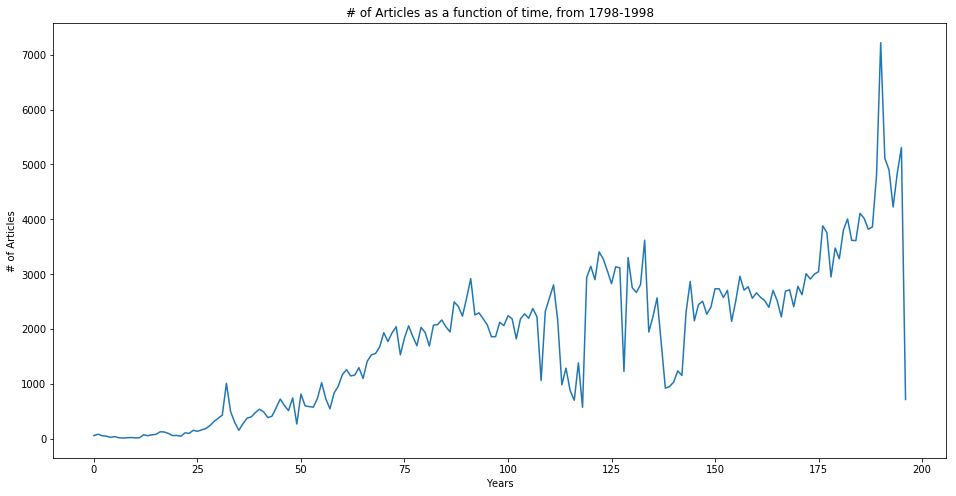

In [171]:
ax = df_year.counts.plot(kind='line', figsize=(16,8))
ax.set_xlabel('Years')
ax.set_ylabel('# of Articles')
ax.set_title('# of Articles as a function of time, from 1798-1998');

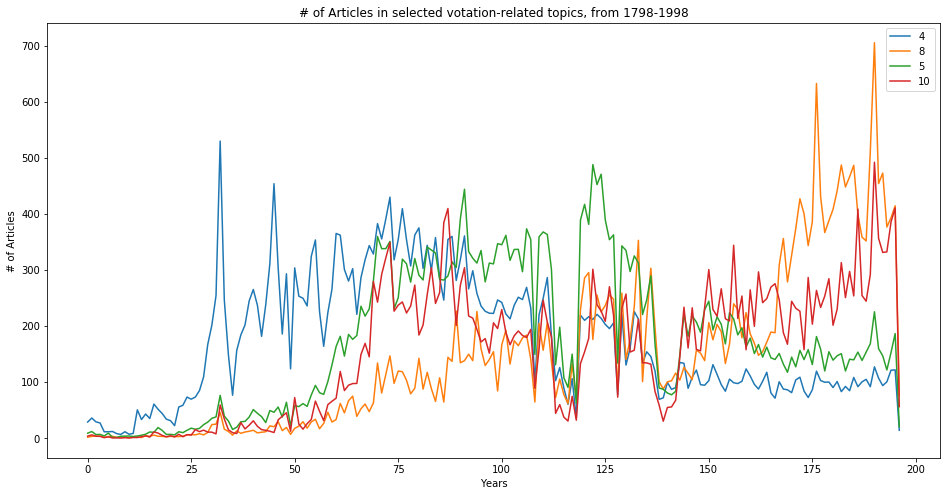

In [170]:
ax = df_year['4'].plot(kind='line', figsize=(16,8), legend=True)
ax = df_year['8'].plot(kind='line', figsize=(16,8), legend=True)
ax = df_year['5'].plot(kind='line', figsize=(16,8), legend=True)
ax = df_year['10'].plot(kind='line', figsize=(16,8), legend=True)
ax.set_xlabel('Years')
ax.set_ylabel('# of Articles')
ax.set_title('# of Articles in selected votation-related topics, from 1798-1998');

In these 4 cases there aren't obvious declines or increases. Rather there is sometimes very sharp increases on occasion, these may be correlated to a very hot current topic that is written about profusely. 

Topic 5 is relatively interesting as it contains the keywords 'européen' and 'américain'. We can see a sharp increase about 60  years into the dataset in about 1858. This time period roughly corresponds with a boom of industrialisation, and possibly more interest for neighbouring countries due to increasing trade. The link is even more interesting because the articles that we are observing have been filtered with votation-related keywords. This possibly suggested a rise in legislation and votation in relation to the outside world and trade.

Topics 4 and 8 are the biggest in size that contain both the 'référendum' and 'initiative' keywords. We can see their increase during this industrialisation boom, the two dips for both wars and finally what seems to be a continuing increase until 1998. This would quite strongly suggest that at least in these two topics the fraction of articles published has been increasing, at least since the second world war.

In [117]:
# Normalisation
df_norm = df_year
topic_cols=['1','2','3','4','5','6','7','8','9','10']
df_norm.counts = df_norm.counts.astype('int')
df_norm[topic_cols] = df_norm[topic_cols].astype('float')
for i in topic_cols:
    df_norm[i] = df_norm[i]/df_norm.counts

In [118]:
df_norm.to_csv('df_norm.csv')
# df_norm = pd.read_csv('df_norm.csv')

In [119]:
df_norm.head()

,1,2,3,4,5,6,7,8,9,10,month,year,counts
0,0.061859,0.049160,0.015962,0.450127,0.139915,0.036145,0.022337,0.030167,0.137203,0.057125,465.0,1798,64
1,0.043315,0.028017,0.019903,0.414441,0.137464,0.026087,0.028731,0.036757,0.197233,0.068051,622.0,1799,87
2,0.025542,0.024396,0.065667,0.494438,0.110992,0.007187,0.034992,0.067116,0.108848,0.060822,414.0,1804,59
3,0.023412,0.027619,0.070613,0.513448,0.128940,0.005545,0.036922,0.071121,0.059878,0.062502,299.0,1805,53
4,0.039553,0.057084,0.118614,0.383313,0.138127,0.009191,0.080508,0.053804,0.085508,0.034298,197.0,1806,30


Now we may plot the relative number of articles that are in relation to direct democracy keywords. In this case we can pick 'référendum' and 'initiative' as two representative words. 

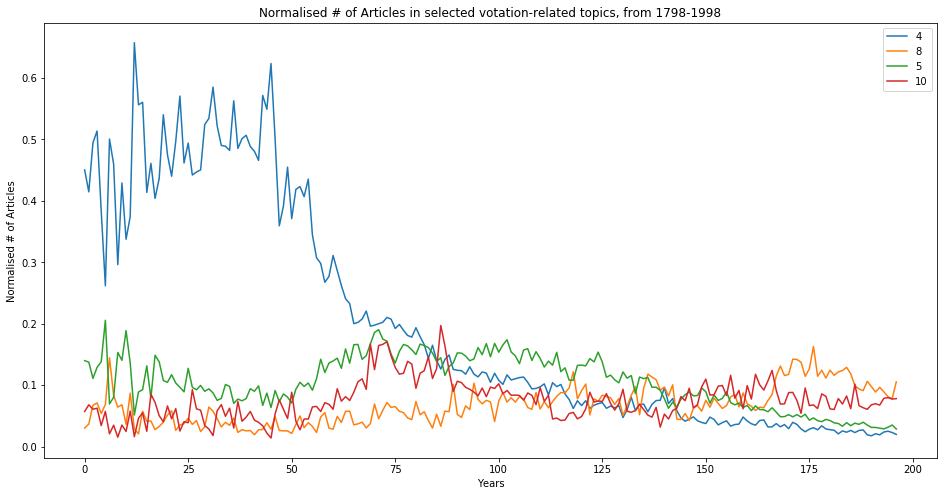

In [172]:
ax = df_norm['4'].plot(kind='line', figsize=(16,8), legend=True)
ax = df_norm['8'].plot(kind='line', figsize=(16,8), legend=True)
ax = df_norm['5'].plot(kind='line', figsize=(16,8), legend=True)
ax = df_norm['10'].plot(kind='line', figsize=(16,8), legend=True)
ax.set_xlabel('Years')
ax.set_ylabel('Normalised # of Articles')
ax.set_title('Normalised # of Articles in selected votation-related topics, from 1798-1998');

The first striking trend in the normalised version of this data is the very steep decrease in topic 4 from about 1850-1900. However, this is in the first 50 years of the dataset, due to the relatively small number of articles and how the data is normalised these may be outliers. Although this high importance normalised # of Articles year after year would suggest that it isn't just a yearly outlier. It may very well be that this topic was very popular in the first half of the 1800s and gradually died out. Some of the most probable words associated with topic 4 are:
* referendum 
* peupler
* populaire
* initiative
* question
* politique

This seems to be related in a rather broad sense to direct democracy, although the 'peupler' keyword indicates another key term. 

Given that topic 8 is also one of the two big topics with 'initiative' and 'referendum', its relative stability on the above graph suggests it hasn't changed much during the years. The steep decline of topic 4 can indicate a large shift in the articles that treat with direct democracy and the themes of these.

## Grouping by Month
In this case the idea is to repeat the previous analysis, but rather to group by month and see if we can observe any seasonal patterns.

In [184]:
df_month = pd.DataFrame(columns=df.columns[5:])
# years=['1798','1799']
counts =[]
for month in df.month.unique():
    counts.append(df[df['month']==month].shape[0])
    df_month = df_month.append(df[df['month']==month][df.columns[5:]].sum(), ignore_index=True)
    
df_month = df_month.join(pd.DataFrame(df.month.unique(), columns=['month']))
df_month = df_month.join(pd.DataFrame(counts, columns=['counts']))

In [185]:
# df_month.to_csv('df_month.csv')
df_month = pd.read_csv('df_month.csv')
df_month = df_month.drop(['Unnamed: 0'],axis=1)
df_month.head()

,1,2,3,4,5,6,7,8,9,10,month,counts
0,2487.891052,3113.474239,2829.719350,2800.559388,2983.847803,2570.073777,3212.716978,2480.760835,4344.678039,2290.278539,2,29114
1,2744.386727,3573.361010,3702.164760,3189.382475,3611.363132,2995.843701,4042.985102,2672.131121,5026.048989,2933.332983,3,34491
2,2339.643061,3042.722716,3240.217515,2820.515333,2624.312742,2309.214292,3794.512283,2217.057885,4384.457770,2466.346404,4,29239
3,2610.917970,3386.391259,3786.575240,3400.032877,2986.282146,2699.646134,4018.909300,2488.382172,4785.696263,2813.166639,5,32976
4,2569.076675,3423.712983,2586.268095,2972.540578,3641.748302,2978.804972,3943.323535,2679.549030,4713.316287,2771.659543,6,32280


Text(0,0.5,'# of Articles')

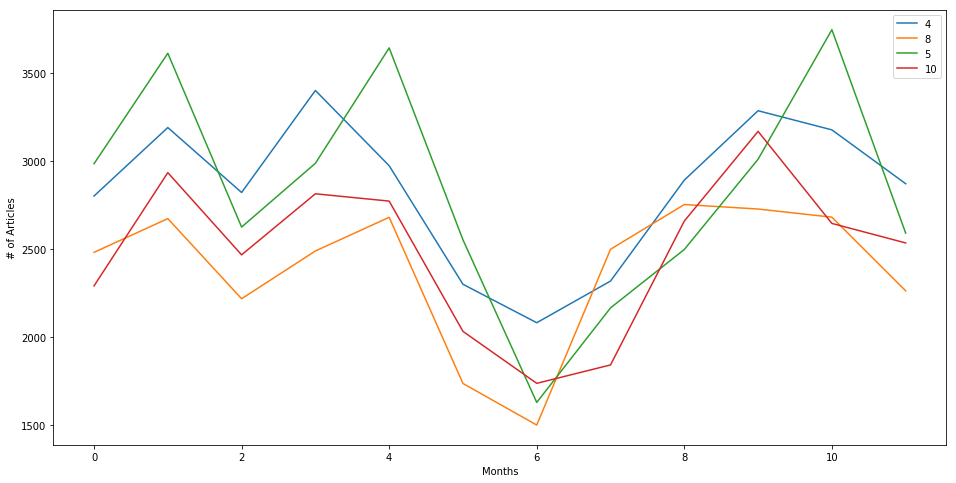

In [186]:
ax = df_month['4'].plot(kind='line', figsize=(16,8), legend=True)
ax = df_month['8'].plot(kind='line', figsize=(16,8), legend=True)
ax = df_month['5'].plot(kind='line', figsize=(16,8), legend=True)
ax = df_month['10'].plot(kind='line', figsize=(16,8), legend=True)
ax.set_xlabel('Months')
ax.set_ylabel('# of Articles')
ax.set_title('# of Articles per month from selected topics, from 1798-1998');

We can see a very large dip during July. Conclusion? Direct democracy and voting in general isn't that much of a hot topic in summer.

Let's normalise the data as we did previously and see if this trend changes. In this case the normalisation will work similarly to before, in that the graph with the absolute # of Articles is biased to more modern times because more has been published.

In [187]:
# Normalisation
df_mn = df_month
topic_cols=['1','2','3','4','5','6','7','8','9','10']
df_mn.counts = df_mn.counts.astype('int')
df_mn[topic_cols] = df_mn[topic_cols].astype('float')
for i in topic_cols:
    df_mn[i] = df_mn[i]/df_mn.counts

In [188]:
df_mn.to_csv('df_mn.csv')
# df_norm = pd.read_csv('df_mn.csv')
# df_norm = df_norm.drop(['Unnamed: 0'],axis=1)

df_mn.head()

,1,2,3,4,5,6,7,8,9,10,month,counts
0,0.085453,0.106941,0.097194,0.096193,0.102488,0.088276,0.110350,0.085209,0.149230,0.078666,2,29114
1,0.079568,0.103603,0.107337,0.092470,0.104705,0.086859,0.117219,0.077473,0.145721,0.085046,3,34491
2,0.080018,0.104064,0.110818,0.096464,0.089754,0.078977,0.129776,0.075825,0.149952,0.084351,4,29239
3,0.079176,0.102693,0.114828,0.103106,0.090559,0.081867,0.121874,0.075460,0.145127,0.085310,5,32976
4,0.079587,0.106063,0.080120,0.092086,0.112817,0.092280,0.122160,0.083010,0.146014,0.085863,6,32280


Text(0,0.5,'# of Articles')

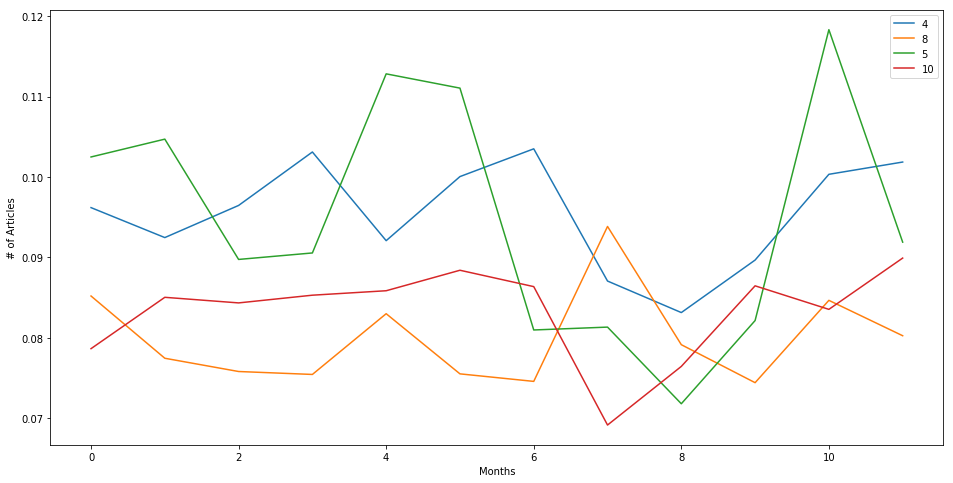

In [189]:
ax = df_month['4'].plot(kind='line', figsize=(16,8), legend=True)
ax = df_month['8'].plot(kind='line', figsize=(16,8), legend=True)
ax = df_month['5'].plot(kind='line', figsize=(16,8), legend=True)
ax = df_month['10'].plot(kind='line', figsize=(16,8), legend=True)
ax.set_xlabel('Months')
ax.set_ylabel('# of Articles')

Although not as pronounced as before, we can also see that most of the chosen direct-democracy topics lose their popularity in the summer vacation months. Except topic 8, which is about 'federal','suisse' and 'canton'

## Overall view
Here we present an overall view of the evolution of the different topics throughout the 200 years of data. This is purely meant as an overview to see how the number of articles in each topic has changed over the years (non-normalised) and how the share of each different topic has evolved (normalised). Of all the data that has been shown here there is of course much more analysis that could be performed, this was more of an exploration into these different topics and how we can see the themes of votation changing through time.

Text(0.5,1,'Overal view of the evolution of the number of articles in different topics from 1798-1998')

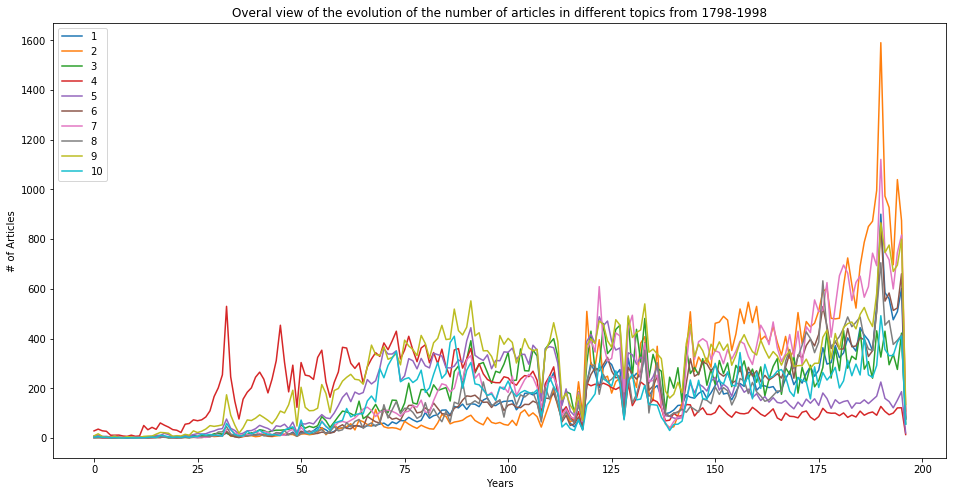

In [86]:
for i in topic_cols:
    ax = df_year[i].plot(kind='line', figsize=(16,8), legend=True)

ax.set_xlabel('Years')
ax.set_ylabel('# of Articles')
ax.set_title('Overal view of the evolution of the number of articles in different topics from 1798-1998')


Text(0.5,1,'Normalised overal view of the evolution of the number of articles in different topics from 1798-1998')

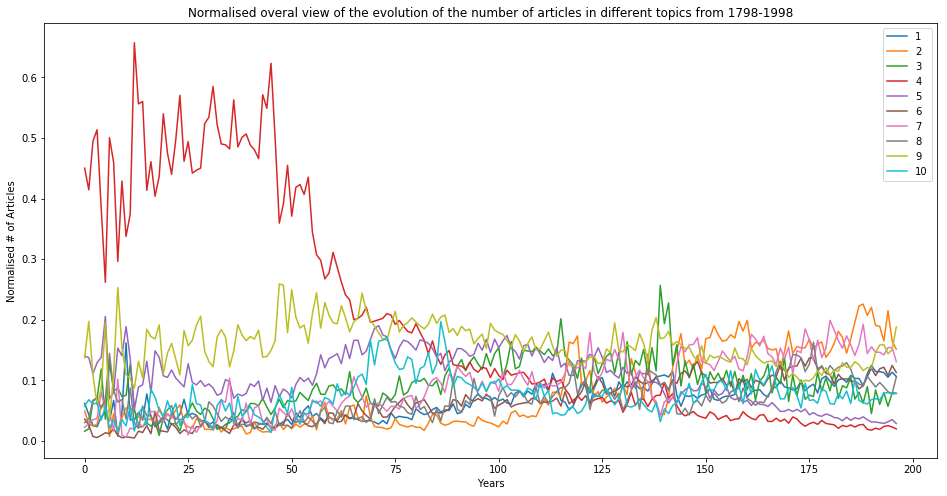

In [92]:
for i in topic_cols:
    ax = df_norm[i].plot(kind='line', figsize=(16,8), legend=True)

ax.set_xlabel('Years')
ax.set_ylabel('Normalised # of Articles')
ax.set_title('Normalised overal view of the evolution of the number of articles in different topics from 1798-1998')
